In [63]:
import requests
import json
import subprocess
import matplotlib.pyplot as plt

# Estructura component

El component ha de poder executar un codi agnòstic. Es pot començar simplificant el problema fent que aquest codi agnòstic està dins d'un arxiu .py.  
Aquest arxiu .py estarà dins d'un docker.  
El docker estarà montat amb una base de fastapi.  
La crida al component, hauria d'aixecar el docker, amb uns paràmetres d'entrada. El docker executaria el codi .py, i automàticament enviaria el resultat de l'execució de tornada mitjançant fastapi  

Patrón de diseño Command Pattern

# Component V1

docker build -t componente-v1.0 -f Dockerfile .

docker run -e SCRIPT_PATH=/path/to/script.py -e ARGS="arg1 arg2 arg3" -e URL=http://api-access-manager.com/path componente-v1.0



docker run -it --rm mi-imagen python /tests/componente_tests.py

"calculos.py" debe enviar por stdout los resultados del cálculo en formato json (o str en su defecto).



## Crides

In [8]:
resultado = {"data": {"a" : 1}}
url = "http://localhost:8080/run"
headers = {"Content-Type": "application/json"}
response = requests.post(url, headers=headers, data=json.dumps(resultado))
print(response)
print(response.text)

<Response [200]>
{"status":1000}


In [132]:
url = "http://localhost:8080/results"
headers = {"Content-Type": "application/json"}
resultado =  { "a" : 1 }
response = requests.post(url, headers=headers, data=json.dumps(resultado))
json.dumps(resultado)

'{"a": 1}'

In [118]:
docker_image_name = "componente-v1.0"
script_path = "calculos.py"
args = "arg1 arg2 arg3"
url = "http://host.docker.internal:8080/results"
docker_command = ["docker", "run", "-e", f"SCRIPT_PATH={script_path}", "-e", f'ARGS="{args}"', "-e", f'URL={url}', docker_image_name]
process = subprocess.run(docker_command)
process

CompletedProcess(args=['docker', 'run', '-e', 'SCRIPT_PATH=calculos.py', '-e', 'ARGS="arg1 arg2 arg3"', '-e', 'URL=http://host.docker.internal:8080/results', 'componente-v1.0'], returncode=0)

In [34]:
docker_image_name = "componente-v1.0"
script_path = "calculos.py"
args = "arg1 arg2 arg3"
url = "http://host.docker.internal:8080/results"
docker_command = f'docker run -e SCRIPT_PATH={script_path} -e ARGS="{args}" -e URL={url} {docker_image_name}'
process = subprocess.run(docker_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE,text=True)

'{"a": 1}'

In [46]:
script_path = "..\src\componente_v1\calculos.py"
try:
    with open(script_path, 'r') as file:
        print('El archivo calculos.py es accesible')
except FileNotFoundError:
    print('El archivo calculos.py no es accesible')

El archivo calculos.py es accesible


## Howto


* Construir imagen  
docker build -t componente-v1.0 -f Dockerfile .

* Para abrir el access manager   
python access_manager_simulation.py




* Para utilizar terminal dentro del contenedor (principalmente debugguear)  
docker run -it componente-v1.0 bash


In [4]:
script_name = "script_1_calculadora.py"
script_arguments = "2 3"

data = {"script_path": script_name, "arguments": script_arguments}
run_script_url = "http://localhost:8080/run"
headers = {"Content-Type": "application/json"}
response = requests.post(run_script_url, headers=headers, json=data)
print(response, response.text)

<Response [202]> {"status":"started","PID":5560}


## Modificacions  

* No s'executarà codi aliè.  
* Dos approaches, T2.3 i T2.4
* No s'executarà un docker per procés, els processos menys intensos seràn scripts a l'entorn
  que s'executaràn. Els més intensos sí que es faràn en un contenidor apart.


## Jofre: Preguntar cas d'us?  
  * Qui és?
  * Què ens ha proporcionat?
  * Quin context necessito per formular una pregunta més coherent informativa que "Com ho utilitzaries?"
## Diagrama de sqüència: Com faràn les dades? Per on passaràn?
  * Com faràn les dades?
  * Per on passaràn?
  * Visio?


# Component v2


Para construir el contenedor:
> docker build -t componente-v2 -f Dockerfile .  

Para correr el contenedor:  
> docker run -p 8000:8000 componente-v2  
 
Si quiero tener la unidad montada en /datasets para ver el resultado  
> docker run -p 8000:8000 -v C:\Users\ian.palacin\Desktop\projects\IMPETUS\src\componente_v2\datasets:/app/datasets componente-v2

De esta forma se ejecuta el comando ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8000"], que deja corriendo una api en el contenedor, esta será la responsable de recibir órdenes. La api está en main.py, desde allí se orquestará la:
* Recepción de órdenes des del Acess Manager (de momento simulado)
* Ejecución del proceso
* Envío de la salida del proceso de vuelta al Access Manager


### Development

Component
> uvicorn main:app --host 0.0.0.0 --port 8000 --reload  

Clean procedure  
>python procedures\clean_procedure.py datasets\racha_max_manresa_2_columns_api.json --output_path datasets\out.csv

# INTERFICIE

In [6]:
import requests
import json
import pandas as pd
import plotly.graph_objects as go

In [86]:
# Vull processar les meves dades amb el procés de data cleaning
url = "http://127.0.0.1:8080/run"
headers = {"Content-Type": "application/json"}
payload = { 
    "script_name": "clean_procedure.py",
    "args": ["datasets/racha_max_manresa_2_columns_api.json",  "--output_path", "datasets/out1.csv"]
    # "args": ["datasets/racha_max_manresa_2_columns.json",  "--output_path", "datasets/out3.csv"]
}
response = requests.post(url, headers=headers, data=json.dumps(payload))
print(response)
print(response.text)

<Response [200]>
{"message":"Ejecutando clean_procedure.py con argumentos: datasets/racha_max_manresa_2_columns.json --output_path datasets/out3.csv"}


In [67]:
df_racha_raw = pd.read_csv( "..\src\componente_v2\datasets\\racha_max_manresa_2_columns.csv")
# df_racha_processed = pd.read_csv( "..\src\componente_v2\datasets\\racha_max_manresa_20230809_110038.csv")
# df_racha_processed = pd.read_csv( "..\src\componente_v2racha_max_manresa_20230810_091920.csv")
df_racha_processed = pd.read_csv(r"C:\Users\ian.palacin\Desktop\projects\IMPETUS\src\componente_v2\datasets\out2.csv")

In [68]:
trace_raw = go.Scatter(x=df_racha_raw.index, y=df_racha_raw['RachaMax'], mode='lines', name='Raw')
trace_processed = go.Scatter(x=df_racha_processed.index, y=df_racha_processed['RachaMax'], mode='lines', name='Processed')
fig = go.Figure(data=[trace_raw, trace_processed])
fig.show()

# Lab

In [ ]:
import pandas as pd
df = pd.read_excel( r"..\src\componente_v2\datasets\viento_manresa.xlsx" )
df = df[['FECHA', 'Racha Max (Km/h)']]
df.to_csv(r"..\src\componente_v2\datasets\racha_max_manresa.csv")



# Mask logic developement

In [ ]:
class ZScoreOutlierRemoval(cp.DataCleaningMethod):
    
    def __init__(self, threshold=2):
        self.threshold = threshold

    def clean(self, data):
        z_scores = np.abs(stats.zscore(data))
        mask = (z_scores < self.threshold)
        data_processed = data[mask]
        return data_processed


In [ ]:
config_json_path = r"C:\Users\ian.palacin\Projectes\impetus-utils\src\componente_v2\datasets\racha_max_manresa_2_columns_api.json"
with open(config_json_path) as f:
    config = json.load(f)
    
cleaner = cp.DataCleaner(data_source_type=config['data_source_type'], data_source=config['data_source'], config=config)
df_pre_clean = cleaner.load_data_from_api(config['data_source'], config['api_additional_info'])
# cleaner.load_data()
# cleaner.clean_data(config["methods"])
# df_clean = cleaner.data

NameError: name 'json' is not defined

In [ ]:
# df = df_pre_clean.copy()
timedelta =  (df.index.to_series() - df.index.to_series().shift(1))
timedelta


date_observed
2011-01-14 00:00:00               NaT
2011-01-15 00:00:00   1 days 00:00:00
2011-01-16 00:00:00   1 days 00:00:00
2011-01-17 00:00:00   1 days 00:00:00
2011-01-18 00:00:00   1 days 00:00:00
                            ...      
2022-12-27 00:10:00   0 days 08:30:00
2022-12-28 18:40:00   1 days 18:30:00
2022-12-29 17:50:00   0 days 23:10:00
2022-12-30 13:20:00   0 days 19:30:00
2022-12-31 03:20:00   0 days 14:00:00
Name: date_observed, Length: 4261, dtype: timedelta64[ns]

In [ ]:
import numpy as np

a = [1,2,3,2]
mask = [True,False,True,False]
array = np.where(mask, 0, a)
array

array([0, 2, 0, 2])

In [ ]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Plotting result of clean_procedure.py

In [153]:
import sys
import pandas as pd
import json
import matplotlib.pyplot as plt
sys.path.insert(0, r'C:\Users\ian.palacin\Projectes\impetus-utils\src\componente_v2')
import procedures.clean_procedure as cp

In [154]:
config_json_path = r"C:\Users\ian.palacin\Projectes\impetus-utils\src\componente_v2\datasets\racha_max_manresa_2_columns_api.json"
with open(config_json_path) as f:
    config = json.load(f)

In [3]:
config

{'data_source_type': 'api',
 'data_source': 'https://data-manager.climate-impetus.eu/access/historical/entities',
 'api_additional_info': {'start_time': '2011-01-14T00:00:00',
  'end_time': '2023-01-20T00:00:00',
  'entity_type': 'windsensor',
  'format': 'COLUMN',
  'origin': 'DEVICE'},
 'methods': {'avg_speed': [[['ZScoreOutlierMask', 2], ['ZeroMaskImputation']],
   [['ZScoreOutlierMask', 2], ['ZeroMaskImputation']]],
  'max_wind_gust': []}}

In [155]:
    
cleaner = cp.DataCleaner(data_source_type=config['data_source_type'], data_source=config['data_source'], config=config)
df_pre_clean = cleaner.load_data_from_api(config['data_source'], config['api_additional_info'])
cleaner.load_data()
cleaner.clean_data(config["methods"])
df_clean = cleaner.data

DATA SOURCE https://data-manager.climate-impetus.eu/access/historical/entities
2 dict_items([('avg_speed', [[['ZScoreOutlierMask', 2], ['ZeroMaskImputation']], [['ZScoreOutlierMask', 2], ['ZeroMaskImputation']]]), ('max_wind_gust', [])])
[['ZScoreOutlierMask', 2], ['ZeroMaskImputation']]
[['ZScoreOutlierMask', 2], ['ZeroMaskImputation']]


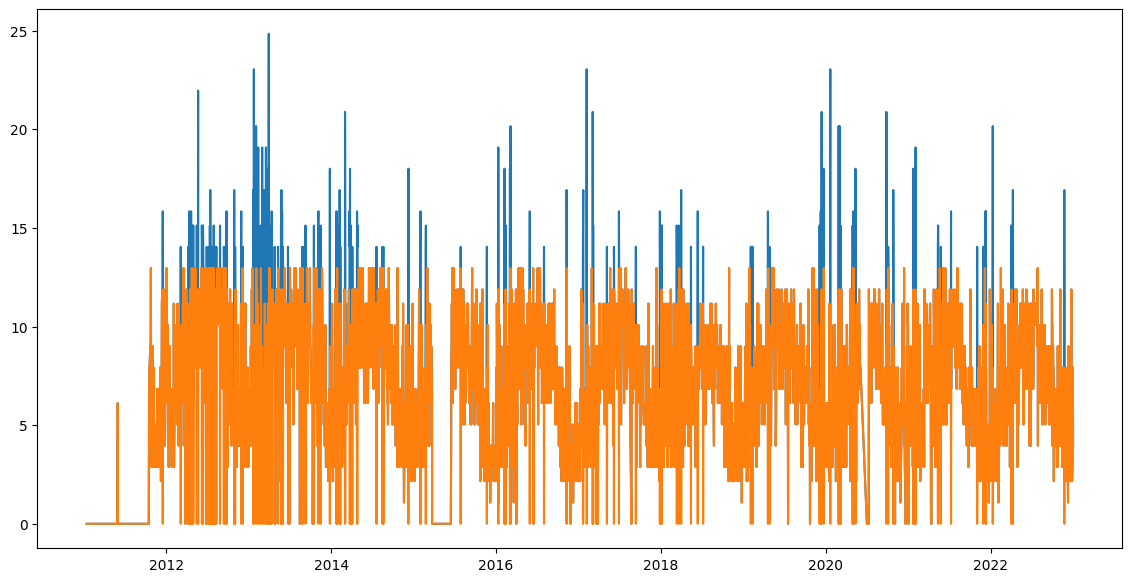

In [3]:
df_joint = pd.DataFrame( {"avg_speed_raw": df_pre_clean['avg_speed'], "avg_speed_processed":df_clean['avg_speed']} )
_ = plt.figure( figsize =(14, 7))
_ = plt.plot(df_joint)

# Streamlit v1

In [1]:
general_functions = []  # Tus funciones generales
mask_generators = ["ZScoreOutlierMask"]  # Generadores de máscaras
mask_imputators = ["ZeroMaskImputation"]  # Imputadores específicos de máscaras
# data = {
#   "arg_0_1": 3,
#   "function_0_1": "ZScoreOutlierMask",
#   "function_0_3": "ZScoreOutlierMask",
#   "imputator_0_4": "ZeroMaskImputation",
#   "variable_0_0": "avg_speed",
#   "arg_0_3": 4,
#   "imputator_0_2": "ZeroMaskImputation"
# }

data = {
  "arg_0_1": 3,
  "function_0_1": "ZScoreOutlierMask",
  "variable_0_0": "avg_speed",
  "imputator_0_2": "ZeroMaskImputation",
  "variable_1_0": "max_wind_gust",
  "imputator_1_2": "ZeroMaskImputation",
  "function_1_1": "ZScoreOutlierMask",
  "arg_1_1": 4
}


In [261]:
values_to_variables = {0: "variable", 1: 'function', 2: 'imputator', 3:'arg'}
variables_to_values = {y: x for x, y in values_to_variables.items()}

elementwise_config = [[variables_to_values[key.split("_")[0]], int(key.split("_")[1]), int(key.split("_")[2])] for key in data.keys()]
elementwise_config.sort(key = lambda row: (row[1],row[2], row[0]))
elementwise_config = [ "_".join([values_to_variables[x],str(y),str(z)]) for [x,y,z] in elementwise_config ]
arg_grouped_list, i = [], 0
while i <= len(elementwise_config)-1:
    if i + 1 < len(elementwise_config) and 'arg_' in elementwise_config[i + 1]:
        arg_grouped_list.append([elementwise_config[i], elementwise_config[i + 1]])
        i += 1
    else:
        arg_grouped_list.append([elementwise_config[i]])
    i += 1

final_list, i = [], len(arg_grouped_list)-1
while i >= 0:
    if 'imputator' in arg_grouped_list[i][0]:
        final_list.append([arg_grouped_list[i-1], arg_grouped_list[i]])
        i -= 1
    else:
        final_list.append([arg_grouped_list[i]])
    i -= 1
final_list = final_list[::-1]
variable = final_list[0][0][0]
methods = [[ [data[component_of_function] for component_of_function in function_with_args] for function_with_args in list_of_functions] for list_of_functions in final_list[1:]]
methods

[[['ZScoreOutlierMask', 3], ['ZeroMaskImputation']],
 [['max_wind_gust']],
 [['ZScoreOutlierMask', 4], ['ZeroMaskImputation']]]

In [9]:
def parse_variable_form_to_method(data):
    values_to_variables = {0: "variable", 1: 'function', 2: 'imputator', 3:'arg'}
    variables_to_values = {y: x for x, y in values_to_variables.items()}

    elementwise_config = [[variables_to_values[key.split("_")[0]], int(key.split("_")[1]), int(key.split("_")[2])] for key in data.keys()]
    elementwise_config.sort(key = lambda row: (row[1],row[2], row[0]))
    elementwise_config = [ "_".join([values_to_variables[x],str(y),str(z)]) for [x,y,z] in elementwise_config ]
    arg_grouped_list, i = [], 0
    while i <= len(elementwise_config)-1:
        if i + 1 < len(elementwise_config) and 'arg_' in elementwise_config[i + 1]:
            arg_grouped_list.append([elementwise_config[i], elementwise_config[i + 1]])
            i += 1
        else:
            arg_grouped_list.append([elementwise_config[i]])
        i += 1

    final_list, i = [], len(arg_grouped_list)-1
    while i >= 0:
        if 'imputator' in arg_grouped_list[i][0]:
            final_list.append([arg_grouped_list[i-1], arg_grouped_list[i]])
            i -= 1
        else:
            final_list.append([arg_grouped_list[i]])
        i -= 1
    final_list = final_list[::-1]
    column = data[final_list[0][0][0]]
    methods = [[ [data[component_of_function] for component_of_function in function_with_args] for function_with_args in list_of_functions] for list_of_functions in final_list[1:]]
    return column, methods



form_to_methods(data)



{'avg_speed': [[['ZScoreOutlierMask', 3], ['ZeroMaskImputation']]],
 'max_wind_gust': [[['ZScoreOutlierMask', 4], ['ZeroMaskImputation']]]}

In [4]:
grouped_data.values()

dict_values([{'arg_0_1': 3, 'function_0_1': 'ZScoreOutlierMask', 'variable_0_0': 'avg_speed', 'imputator_0_2': 'ZeroMaskImputation'}, {'variable_1_0': 'max_wind_gust', 'imputator_1_2': 'ZeroMaskImputation', 'function_1_1': 'ZScoreOutlierMask', 'arg_1_1': 4}])

In [196]:
final_list

[['variable_0_0'],
 ['function_0_1', 'arg_0_1'],
 ['imputator_0_2'],
 ['function_0_3', 'arg_0_3'],
 ['imputator_0_4']]

In [15]:
import pandas as pd
from datetime import datetime

In [28]:
date = pd.to_datetime("2023-11-07").strftime('%Y-%m-%dT%H:%M:%SZ')
date
# pd.to_datetime("2023-11-07 00:00:00")
# datetime.strptime(date, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%dT%H:%M:%SZ')

'2023-11-07T00:00:00Z'

# Solara

In [ ]:
import solara

# Declare reactive variables at the top level. Components using these variables
# will be re-executed when their values change.
sentence = solara.reactive("Solara makes our team more productive.")
word_limit = solara.reactive(10)


@solara.component
def Page():
    # Calculate word_count within the component to ensure re-execution when reactive variables change.
    word_count = len(sentence.value.split())

    solara.SliderInt("Word limit", value=word_limit, min=2, max=20)
    solara.InputText(label="Your sentence", value=sentence, continuous_update=True)

    # Display messages based on the current word count and word limit.
    if word_count >= int(word_limit.value):
        solara.Error(f"With {word_count} words, you passed the word limit of {word_limit.value}.")
    elif word_count >= int(0.8 * word_limit.value):
        solara.Warning(f"With {word_count} words, you are close to the word limit of {word_limit.value}.")
    else:
        solara.Success("Great short writing!")


# The following line is required only when running the code in a Jupyter notebook:
Page()

In [ ]:
from typing import Optional, cast

import pandas as pd

import solara
import solara.express as solara_px  # similar to plotly express, but comes with cross filters
import solara.lab
from solara.components.columns import Columns
from solara.components.file_drop import FileDrop

github_url = solara.util.github_url(__file__)
try:
    # fails on pyodide
    df_sample = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/gapminderDataFiveYear.csv")
except:  # noqa
    df_sample = None


class State:
    size_max = solara.reactive(40.0)
    size = solara.reactive(cast(Optional[str], None))
    color = solara.reactive(cast(Optional[str], None))
    x = solara.reactive(cast(Optional[str], None))
    y = solara.reactive(cast(Optional[str], None))
    logx = solara.reactive(False)
    logy = solara.reactive(False)
    df = solara.reactive(cast(Optional[pd.DataFrame], None))

    @staticmethod
    def load_sample():
        State.x.value = str("gdpPercap")
        State.y.value = str("lifeExp")
        State.size.value = str("pop")
        State.color.value = str("continent")
        State.logx.value = True
        State.df.value = df_sample

    @staticmethod
    def load_from_file(file):
        df = pd.read_csv(file["file_obj"])
        State.x.value = str(df.columns[0])
        State.y.value = str(df.columns[1])
        State.size.value = str(df.columns[2])
        State.color.value = str(df.columns[3])
        State.df.value = df

    @staticmethod
    def reset():
        State.df.value = None


@solara.component
def Page():
    df = State.df.value

    # the .scatter will set this cross filter
    filter, _set_filter = solara.use_cross_filter(id(df))

    # only apply the filter if the filter or dataframe changes
    def filter_df():
        if filter is not None and df is not None:
            return df.loc[filter]

    dff = solara.use_memo(filter_df, dependencies=[df, filter])

    with solara.Sidebar():
        with solara.Card("Controls", margin=0, elevation=0):
            with solara.Column():
                with solara.Row():
                    solara.Button("Sample dataset", color="primary", text=True, outlined=True, on_click=State.load_sample, disabled=df is not None)
                    solara.Button("Clear dataset", color="primary", text=True, outlined=True, on_click=State.reset)
                FileDrop(on_file=State.load_from_file, on_total_progress=lambda *args: None, label="Drag file here")

                if df is not None:
                    solara.SliderFloat(label="Size", value=State.size_max, min=1, max=100)
                    solara.Checkbox(label="Log x", value=State.logx)
                    solara.Checkbox(label="Log y", value=State.logy)
                    columns = list(map(str, df.columns))
                    solara.Select("Column x", values=columns, value=State.x)
                    solara.Select("Column y", values=columns, value=State.y)
                    solara.Select("Size", values=columns, value=State.size)
                    solara.Select("Color", values=columns, value=State.color)
                    if filter is None:
                        solara.Info("If you select points in the scatter plot, you can download the points here.")
                    else:

                        def get_data():
                            return dff.to_csv(index=False)

                        solara.FileDownload(get_data, label=f"Download {len(dff):,} selected points", filename="selected.csv")

    if df is not None:
        with Columns(widths=[2, 4]):
            if State.x.value and State.y.value:
                solara_px.scatter(
                    df,
                    State.x.value,
                    State.y.value,
                    size=State.size.value,
                    color=State.color.value,
                    size_max=State.size_max.value,
                    log_x=State.logx.value,
                    log_y=State.logy.value,
                )
            else:
                solara.Warning("Select x and y columns")

    else:
        solara.Info("No data loaded, click on the sample dataset button to load a sample dataset, or upload a file.")

    solara.Button(label="View source", icon_name="mdi-github-circle", attributes={"href": github_url, "target": "_blank"}, text=True, outlined=True)


@solara.component
def Layout(children):
    route, routes = solara.use_route()
    return solara.AppLayout(children=children)

In [ ]:
import streamlit as st

from streamlit_jupyter import StreamlitPatcher, tqdm
